(Analisis_Exploratorio)=
# <span style="color:#F72585"><center>Análisis Exploratorio de Modelos Bayesianos</center></span>


## <span style="color:#4361EE">Introducción</span>



Se introducen los elementos esenciales del análisis exploratorio de  Modelos Bayesianos. Usaremos la librería [Arviz](https://arviz-devs.github.io/arviz/){cite}`Kumar_ArviZ_a_unified` que es una librería desarrollada para hacer estos análisis en Python. 

En particular, Arviz puede trabajar con las salidas de Pystan, Pyro y TFP.

En este cuaderno usamos el ejemplo de 8 escuelas (eight schools) {cite}`gelman2003bayesian` que utilizamos en el [primer ejemplo de este curso](1_Ocho_Escuelas)

## <span style="color:#4361EE">El Modelo Estadístico para este tutorial</span>


Supongamos que tenemos observaciones $[y_n |x_n], n=1,\ldots,N$, y asumamos el modelo Bayesiano. 

**Modelo con efectos aleatorios**

- Estima los hiperparámetros $\mu$ and $\tau$
- Predice los efectos aleatorios $\eta_i$


$$
\begin{align}
y_i &\sim \mathcal{N}(\theta_i,\sigma_i^2), \text{ known } \sigma_i^2\\
\theta_i & = \mu + \tau \times \eta_i \\
\eta_i &\sim \mathcal{N}(0, 1)\\
\mu &\sim \mathcal{N}(0, 5)\\
\tau &\sim \mathcal{Cauchy}(0, 5)1_{\tau>0.0}
\end{align}
$$



### <span style="color:#4CC9F0">Los datos</span>

Los datos corresponden a la estimación (estandarizada) de un puntaje realizada en las ocho escuelas observadas.


```{table}
|School |Estim. Treatment Effect | Estim. Stand. Error |
|---|---|---|
|A |28| 15|
|B |8 |10|
|C| -3| 16|
|D| 7| 11|
|E| -1 |9|
|F| 1| 11|
|G |18| 10|
|H| 12| 18|
```

````{tab} Pyro
```python
# Importamos las librerías requeridas
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import MCMC, NUTS
import pyro.distributions.constraints as constraints
# Se requieren instaladas las librerías matplotlib y scipy para los gráficos
```
````

````{tab} TFP
```python
# Importamos las librerías requeridas
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
import warnings
tf.enable_v2_behavior()
# Se requieren instaladas las librerías matplotlib y scipy para los gráficos
```
````

````{tab} Stan
``` r
# Importamos las librerías requeridas
import pystan
import numpy as np
# Se requieren instaladas las librerías matplotlib y scipy para los gráficos

```
````

````{tab} Pyro
```python
# Los datos
J = 8 #Número de escuelas
y = torch.tensor([28, 8, -3, 7, -1, 1, 18, 12]).type(torch.Tensor) #Estimaciones de los efectos del tratamiento
sigma = torch.tensor([15, 10, 16, 11, 9, 11, 10, 18]).type(torch.Tensor) #Estimacion de la desviacion de los efectos del tratamiento
schools = np.array(['Choate', 'Deerfield', 'Phillips Andover', 'Phillips Exeter',
                    'Hotchkiss', 'Lawrenceville', "St. Paul's", 'Mt. Hermon'])

schools_dat = {'J': J,
               'y': y,
               'sigma': sigma}
schools_dat 
```
````

````{tab} TFP
```python
# Los datos
J = 8 #Número de escuelas
y = np.array([28.,  8., -3.,  7., -1.,  1., 18., 12.], dtype=np.float32) #Estimaciones de los efectos del tratamiento
sigma = np.array([15., 10., 16., 11.,  9., 11., 10., 18.], dtype=np.float32) #Estimacion de la desviacion de los efectos del tratamiento
schools = np.array(['Choate', 'Deerfield', 'Phillips Andover', 'Phillips Exeter',
                    'Hotchkiss', 'Lawrenceville', "St. Paul's", 'Mt. Hermon'])

schools_dat = {'J': J,
               'y': y,
               'sigma': sigma}
schools_dat 
```
````

````{tab} Stan
``` r
schools_dat = {'J': 8,
               'y': [28,  8, -3,  7, -1,  1, 18, 12],
               'sigma': [15, 10, 16, 11,  9, 11, 10, 18]}
schools_dat 
```
````

## <span style="color:#4361EE">Implementación del modelo estadístico</span>


````{tab} Pyro
```python
def schools_code(J,y,sigma):
    mu = pyro.sample('mu',dist.Normal(0,np.sqrt(5)))
    tau = pyro.sample('tau', dist.Cauchy(0,5), constraint=constraints.positive)
    etas = pyro.sample('etas',loc=dist.Normal(torch.zeros(J),scale=torch.ones(J)))
    thetas = mu + tau*etas
    with pyro.plate("plate"):
        pyro.sample("y",dist.Normal(thetas,sigma),obs=y )
```
````
````{tab} TFP
```python
def schools_code(J, y, sigma):
    return tfd.JointDistributionSequential([ 
        #mu
        tfd.Normal(loc=0,scale=np.sqrt(5))
        #tau
        tfd.HalfCauchy(loc=0,scale=5)
        #etas
        tfd.Normal(loc=tf.cast(0,dtype),scale=tf.cast(1,dtype))
        #thetas
        lambda mu, tau, etas: tfd.Sample(mu+ tau*etas,sample_shape=n)
        # y
        lambda thetas, sigma: tfd.independent(tfd.normal (loc= thetas, scale= sigma,name='y'))
        )  
    ])
```
````
````{tab} Stan
``` r
schools_code = """
data {
    int<lower=0> J;
    real y[J];
    real<lower=0> sigma[J];
}

parameters {
    real mu;
    real<lower=0> tau;
    real eta[J];
}

transformed parameters {
    real theta[J];
    for (j in 1:J)
        theta[j] = mu + tau * eta[j];
}

model {
    mu ~ normal(0, 5);
    tau ~ cauchy(0, 5);
    eta ~ normal(0, 1);
    y ~ normal(theta, sigma);
}

generated quantities {
    vector[J] log_lik;
    vector[J] y_hat;
    for (j in 1:J) {
        log_lik[j] = normal_lpdf(y[j] | theta[j], sigma[j]);
        y_hat[j] = normal_rng(theta[j], sigma[j]);
    }
}
"""

```
````


En este código los parámetros que serán muestreados son $\mu$ (*media global*), $\tau$ (*desviación estándar*), y los $\eta_i$ (*eta*) que son los efectos aleatorios en el modelo. Las medias $\theta_i$ de las escuelas son calculados. Es decir, son funcionales de los parámetros.

Hemos asumido las distribuciones a priori para $\mu\sim \mathcal{N}(0,5)$,  $\tau\sim \mathcal{Cauchy}(0,5)1_{\tau>0.0}$ y $\eta_i \sim \mathcal{N}(0,1)$.

Adicionalmente hemos incluido la sección *generated quantities* con el propósito calcular valores útiles para la validación del modelo.

El objeto *log_lik* se usa para calcular la log-verosimilitud (a partir de la función *normal_lpdf*). El objeto *y_hat* se usa para generar réplicas de las observaciones (partir de la función *normal_rng*). Esta es **la distribución predictiva posterior**.



<h2> 4. Compilación del Modelo</h2>

In [7]:
# compile the  model
sm = pystan.StanModel(model_code=schools_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e7c3cbd6ff9855fd1a960862c5979009 NOW.


In [8]:
# extract the samples
fit = sm.sampling(data=schools_dat, iter=1000, chains=4)

In [9]:
fit

Inference for Stan model: anon_model_e7c3cbd6ff9855fd1a960862c5979009.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu           4.37    0.08   3.19  -1.92   2.24   4.34   6.61  10.57   1660    1.0
tau           3.7    0.09   3.29   0.11   1.24   2.86   5.05  12.46   1439    1.0
eta[1]       0.33    0.02   0.99  -1.59  -0.35   0.34   1.01   2.28   2114    1.0
eta[2]        0.1    0.02   0.91  -1.74  -0.49   0.14   0.72   1.87   1969    1.0
eta[3]      -0.08    0.02   0.94  -1.91  -0.71   -0.1   0.54   1.69   2000    1.0
eta[4]       0.09    0.02   0.92  -1.83  -0.51    0.1   0.72   1.81   1894    1.0
eta[5]      -0.15    0.02   0.91  -1.88  -0.75  -0.17   0.44   1.62   2268    1.0
eta[6]      -0.07    0.02   0.94  -1.89  -0.68  -0.08   0.55   1.85   1762    1.0
eta[7]       0.35    0.03   0.99   -1.7  -0.27    0.4   0.97   2.17   1261 

<h2> 5. Inferencia. InferenceData (ArviZ) </h2>

Paar seguir esta parte del tutorial por favor instale ArviZ.

Desde la linea de comandos: 

*pip install arviz*

o mejor use

*conda install -c conda-forge arviz*

[InferenceData](https://arviz-devs.github.io/arviz/notebooks/InferenceDataCookbook.html) es la principal estrutura de datos de ArviZ, la herramienta recomenda para nuestros análisis con Stan. 

In [10]:
# Importamos las librerías requeridas.

import arviz as az
import numpy as np
import pandas as pd
import xarray

# definimos estilos para el fondo de los gráficos y para mostrar la información
az.style.use('arviz-darkgrid')
xarray.set_options(display_style="html");

In [10]:
stan_data = az.from_pystan(
    posterior=fit,
    posterior_predictive='y_hat',
    observed_data=['y'],
    log_likelihood={'y': 'log_lik'},
    coords={'school': schools },
    dims={
        'theta': ['school'],
        'y': ['school'],
        'log_lik': ['school'],
        'y_hat': ['school'],
        'eta': ['school']
    }
)

In [11]:
stan_data

Inference data with groups:
	> posterior
	> sample_stats
	> log_likelihood
	> posterior_predictive
	> observed_data

In [12]:
stan_data.posterior

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 500, school: 8)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * school   (school) <U16 'Choate' 'Deerfield' ... "St. Paul's" 'Mt. Hermon'
Data variables:
    mu       (chain, draw) float64 2.212 3.439 4.428 2.153 ... 4.232 2.503 6.857
    tau      (chain, draw) float64 2.324 0.09161 0.137 4.444 ... 3.393 2.284 3.1
    eta      (chain, draw, school) float64 0.02618 1.168 ... 0.757 0.04841
    theta    (chain, draw, school) float64 2.273 4.927 3.185 ... 9.203 7.007
Attributes:
    created_at:                 2020-04-14T01:47:49.778472
    arviz_version:              0.7.0
    inference_library:          pystan
    inference_library_version:  2.19.0.0

In [16]:
stan_data.posterior.all

<bound method ImplementsDatasetReduce._reduce_method.<locals>.wrapped_func of <xarray.Dataset>
Dimensions:  (chain: 4, draw: 500, school: 8)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * school   (school) <U16 'Choate' 'Deerfield' ... "St. Paul's" 'Mt. Hermon'
Data variables:
    mu       (chain, draw) float64 2.212 3.439 4.428 2.153 ... 4.232 2.503 6.857
    tau      (chain, draw) float64 2.324 0.09161 0.137 4.444 ... 3.393 2.284 3.1
    eta      (chain, draw, school) float64 0.02618 1.168 ... 0.757 0.04841
    theta    (chain, draw, school) float64 2.273 4.927 3.185 ... 9.203 7.007
Attributes:
    created_at:                 2020-04-14T01:47:49.778472
    arviz_version:              0.7.0
    inference_library:          pystan
    inference_library_version:  2.19.0.0>

In [17]:
stan_data.posterior.mu

<xarray.DataArray 'mu' (chain: 4, draw: 500)>
array([[ 2.21206891,  3.43901569,  4.42833692, ...,  4.5852928 ,
         5.52142025,  3.62564956],
       [-2.41618578,  6.75829381,  4.96691781, ...,  6.3789936 ,
         4.62235013,  5.92092435],
       [ 3.48874106,  0.53166951,  1.67469569, ...,  3.29756039,
         1.07000615,  5.73786597],
       [ 2.37870083,  3.5231051 ,  0.8922434 , ...,  4.23167733,
         2.50348969,  6.85666226]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499

In [25]:
val = stan_data.posterior.mu[0,300]
print(val)
print('np.array(val) = ' ,np.array(val))

<xarray.DataArray 'mu' ()>
array(0.93250059)
Coordinates:
    chain    int64 0
    draw     int64 300
np.array(val) =  0.9325005859803573


In [22]:
stan_data.sample_stats

<xarray.Dataset>
Dimensions:      (chain: 4, draw: 500)
Coordinates:
  * chain        (chain) int64 0 1 2 3
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
Data variables:
    accept_stat  (chain, draw) float64 0.9843 0.7251 0.7547 ... 0.9754 0.9426
    stepsize     (chain, draw) float64 0.4391 0.4391 0.4391 ... 0.3713 0.3713
    treedepth    (chain, draw) int64 3 3 3 3 4 3 3 4 3 3 ... 3 3 3 4 3 4 4 4 3 4
    n_leapfrog   (chain, draw) int64 7 7 7 7 31 15 7 23 ... 7 15 7 15 23 15 7 15
    diverging    (chain, draw) bool False False False ... False False False
    energy       (chain, draw) float64 6.24 11.9 10.02 ... 17.6 19.16 17.47
    lp           (chain, draw) float64 -4.309 -3.686 -3.694 ... -13.9 -11.66
Attributes:
    created_at:                 2020-03-29T23:44:37.993593
    arviz_version:              0.7.0
    inference_library:          pystan
    inference_library_version:  2.19.0.0

In [28]:
stan_data.sample_stats.accept_stat


<xarray.DataArray 'accept_stat' (chain: 4, draw: 500)>
array([[0.98937827, 0.85664973, 1.        , ..., 0.55633489, 0.98543347,
        0.90565291],
       [0.689622  , 0.95854725, 0.97832708, ..., 0.6152233 , 1.        ,
        0.66796996],
       [0.99985155, 0.94581298, 0.99241048, ..., 0.96878313, 0.95343739,
        0.94939349],
       [1.        , 0.97375488, 0.93952651, ..., 0.92243911, 0.98030313,
        0.9674844 ]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499

In [23]:
stan_data.log_likelihood

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 500, school: 8)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * school   (school) int64 0 1 2 3 4 5 6 7
Data variables:
    y        (chain, draw, school) float64 -4.693 -3.301 ... -3.873 -3.855
Attributes:
    created_at:                 2020-03-29T23:44:38.001326
    arviz_version:              0.7.0
    inference_library:          pystan
    inference_library_version:  2.19.0.0

In [24]:
stan_data.posterior_predictive

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 500, school: 8)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * school   (school) int64 0 1 2 3 4 5 6 7
Data variables:
    y_hat    (chain, draw, school) float64 25.42 17.5 -11.47 ... 13.29 -3.322
Attributes:
    created_at:                 2020-03-29T23:44:38.005125
    arviz_version:              0.7.0
    inference_library:          pystan
    inference_library_version:  2.19.0.0

In [25]:
stan_data.observed_data

<xarray.Dataset>
Dimensions:  (school: 8)
Coordinates:
  * school   (school) int64 0 1 2 3 4 5 6 7
Data variables:
    y        (school) float64 28.0 8.0 -3.0 7.0 -1.0 1.0 18.0 12.0
Attributes:
    created_at:                 2020-03-29T23:44:37.971742
    arviz_version:              0.7.0
    inference_library:          pystan
    inference_library_version:  2.19.0.0

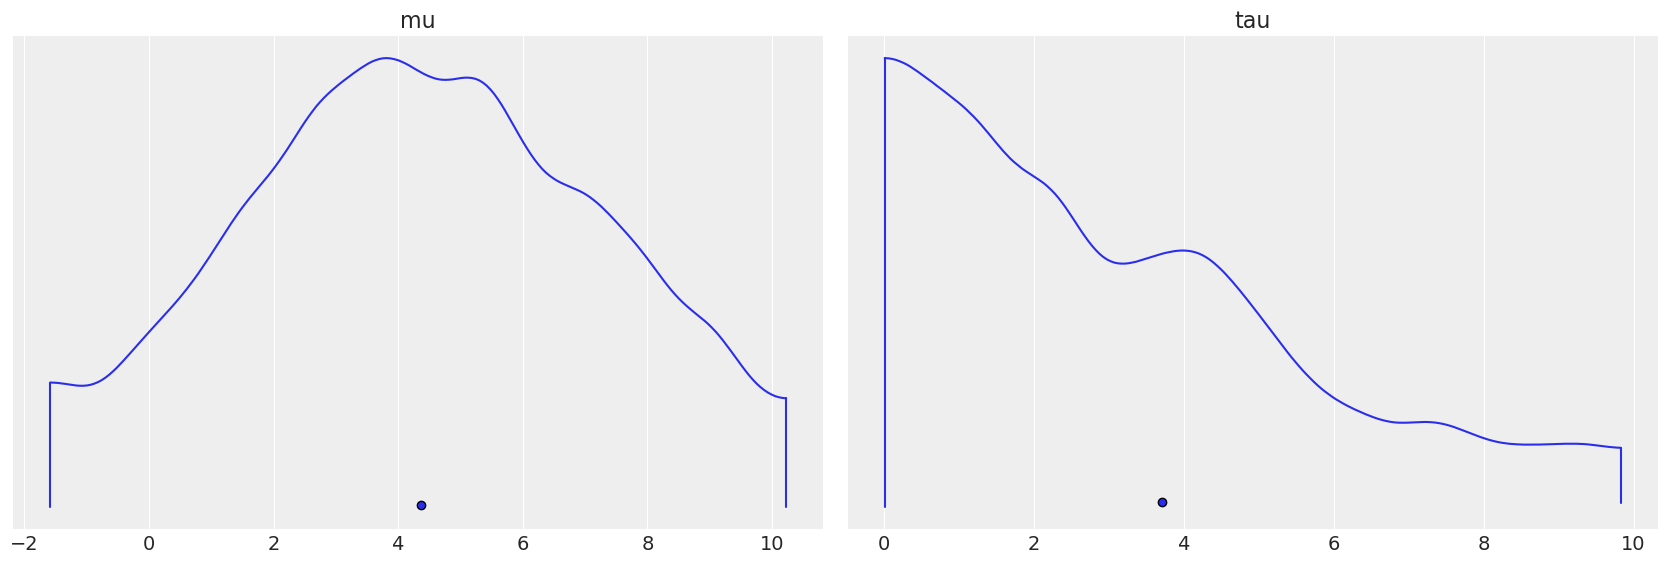

In [29]:
az.plot_density(stan_data, var_names=['mu', 'tau']);

In [30]:
az.plot_density?

Signature:
az.plot_density(
    data,
    group='posterior',
    data_labels=None,
    var_names=None,
    transform=None,
    credible_interval=None,
    point_estimate='auto',
    colors='cycle',
    outline=True,
    hpd_markers='',
    shade=0.0,
    bw=4.5,
    figsize=None,
    textsize=None,
    ax=None,
    backend=None,
    backend_kwargs=None,
    show=None,
)
Docstring:
Generate KDE plots for continuous variables and histograms for discrete ones.

Plots are truncated at their 100*(1-alpha)% credible intervals. Plots are grouped per variable
and colors assigned to models.

Parameters
----------
data : Union[Object, Iterator[Object]]
    Any object that can be converted to an az.InferenceData object, or an Iterator returning
    a sequence of such objects.
    Refer to documentation of az.convert_to_dataset for details about such objects.
group: Optional[str]
    Specifies which InferenceData group should be plotted.  Defaults to 'posterior'.
    Alternative values include 'pr

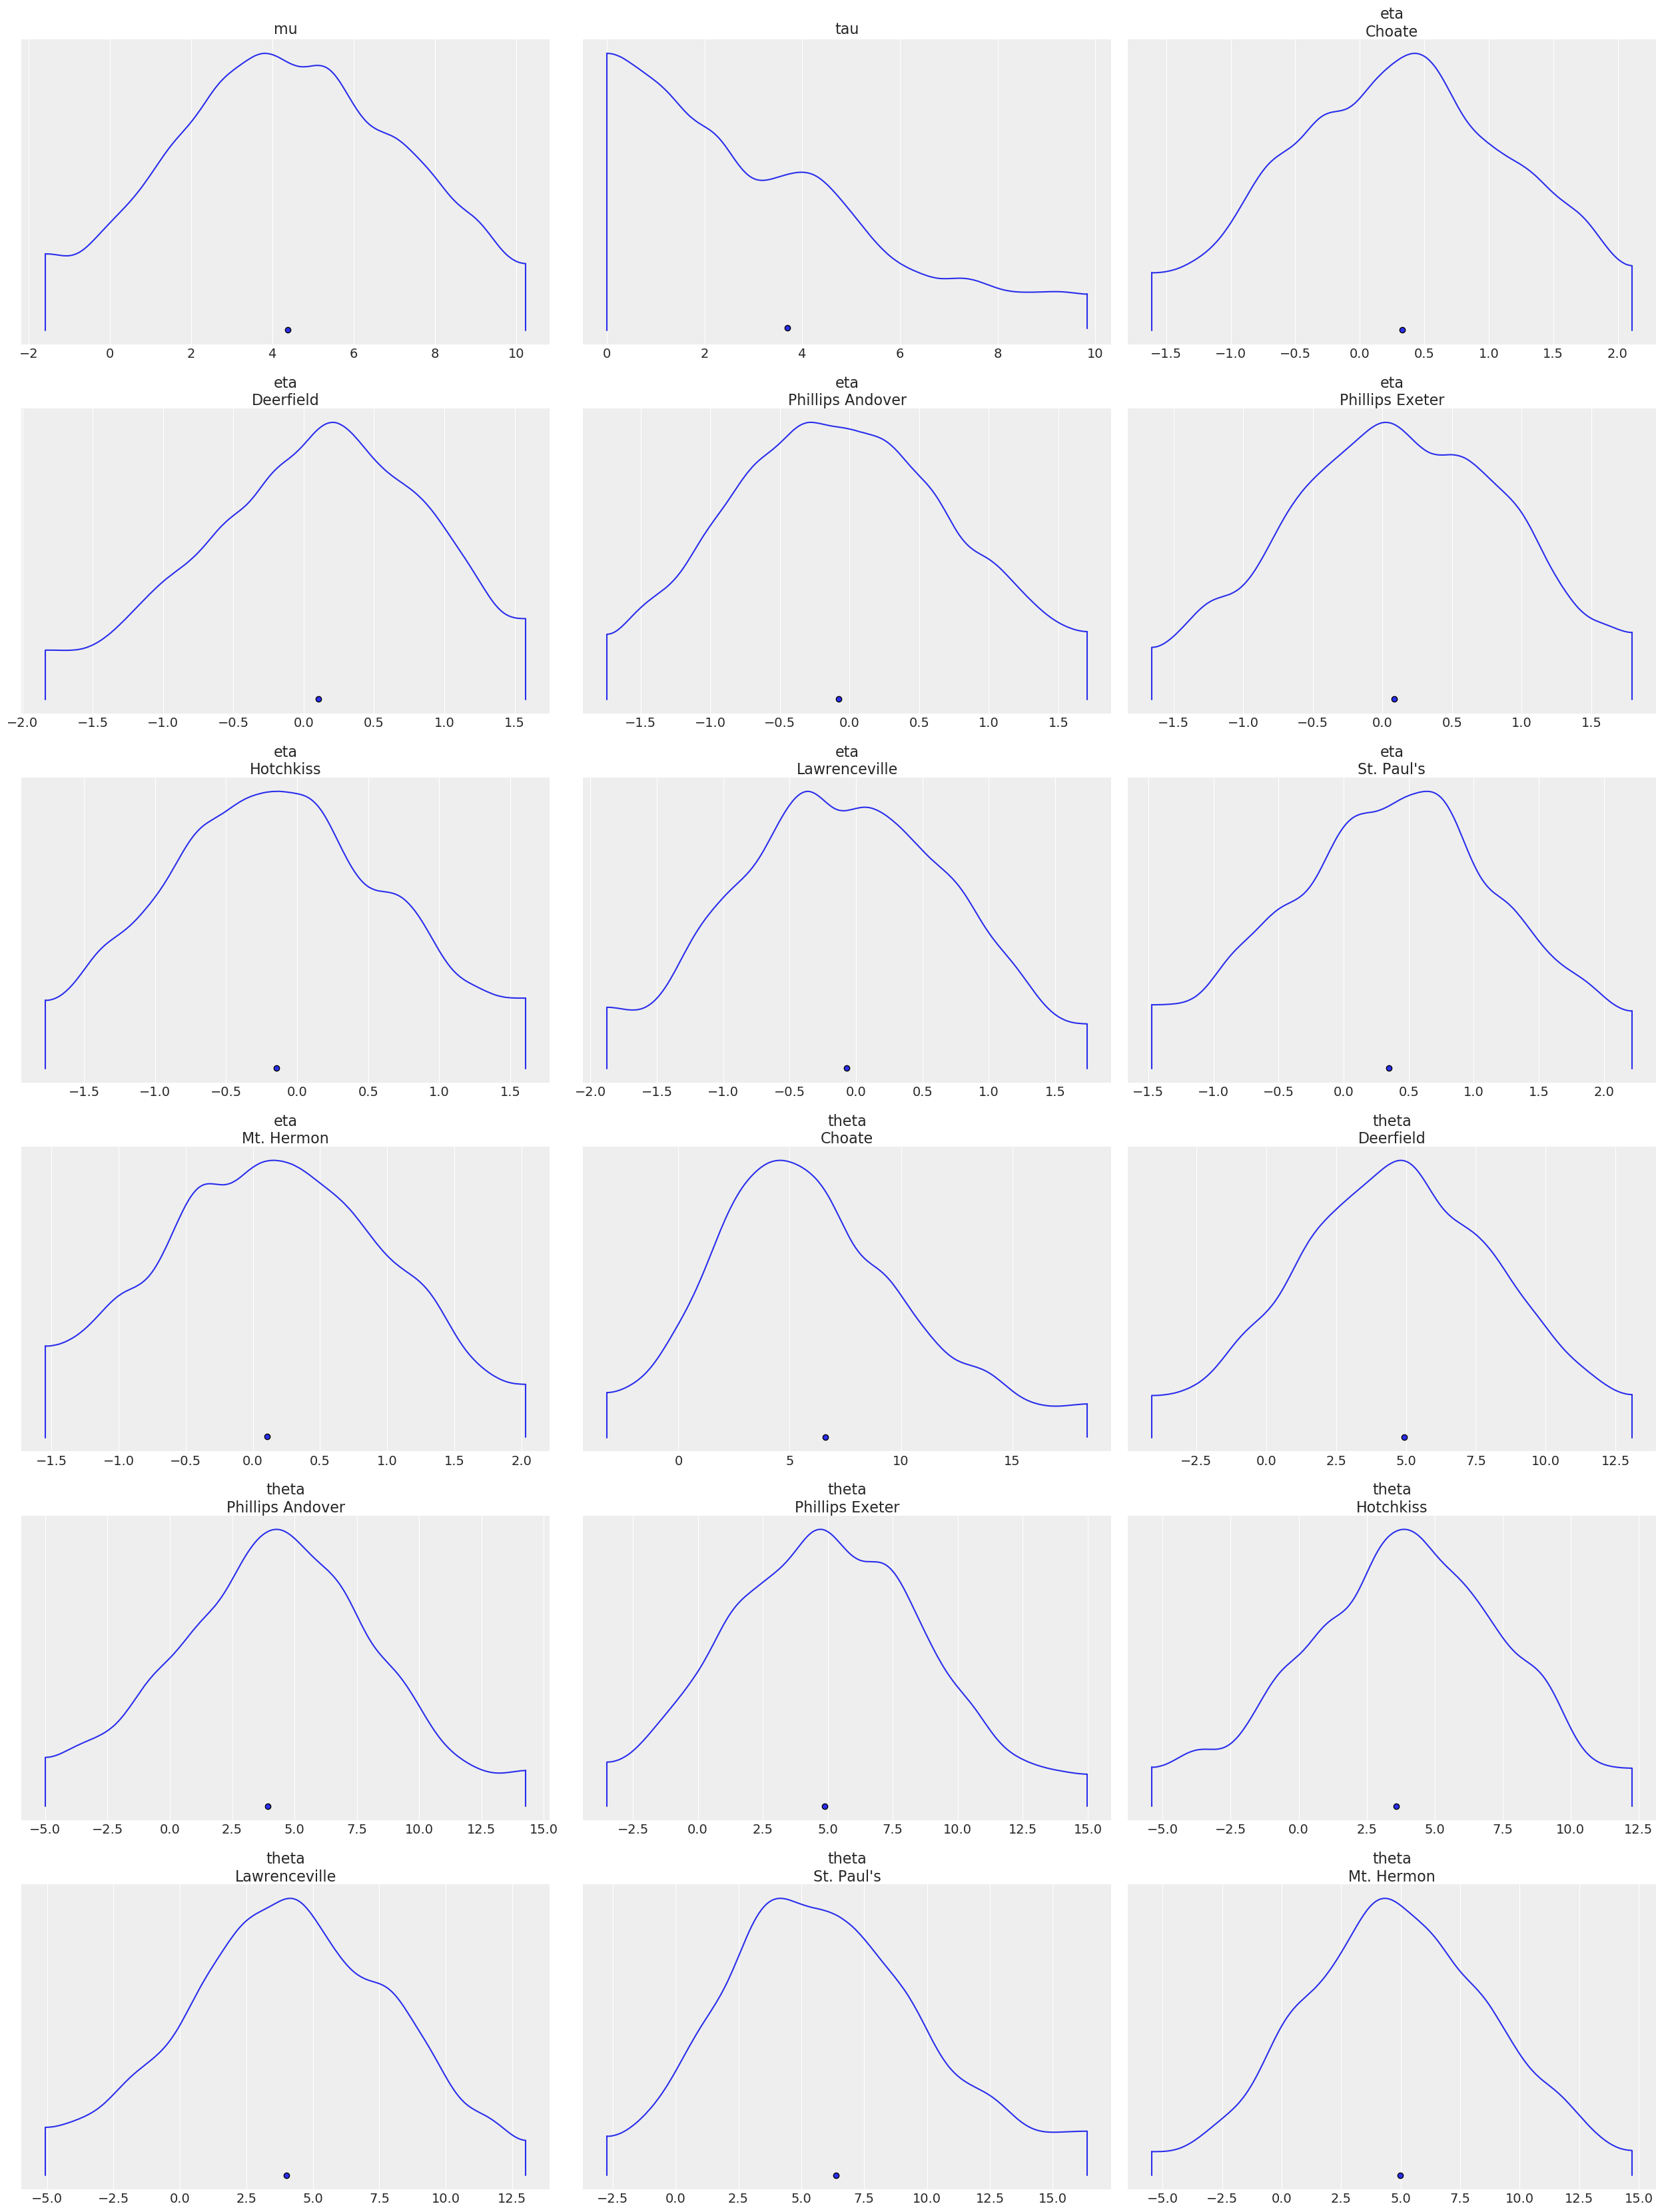

In [31]:
az.plot_density(stan_data);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8e91279b90>,
      dtype=object)

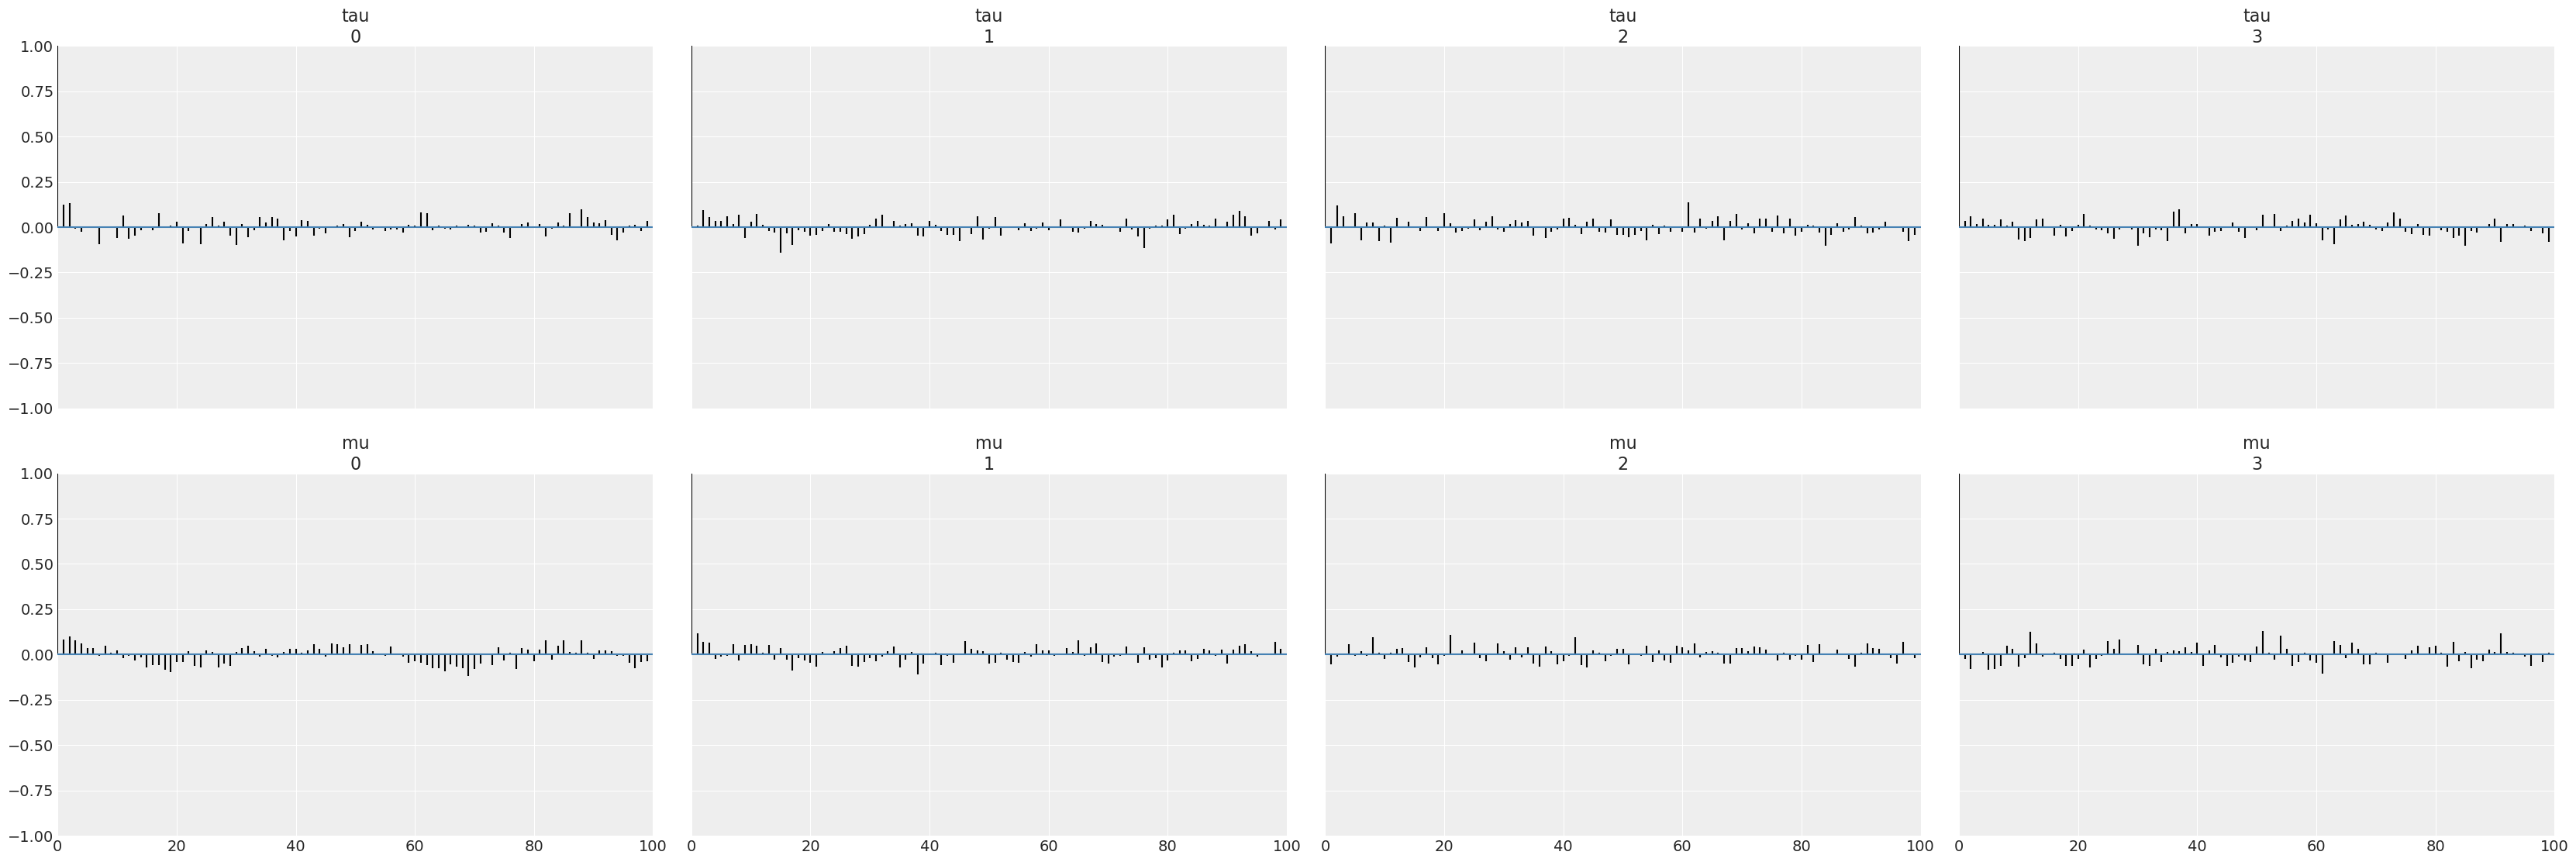

In [32]:
az.plot_autocorr(stan_data, var_names=("tau","mu"))

In [33]:
az.plot_autocorr?

Signature:
az.plot_autocorr(
    data,
    var_names=None,
    max_lag=None,
    combined=False,
    figsize=None,
    textsize=None,
    ax=None,
    backend=None,
    backend_config=None,
    backend_kwargs=None,
    show=None,
)
Docstring:
Bar plot of the autocorrelation function for a sequence of data.

Useful in particular for posteriors from MCMC samples which may display correlation.

Parameters
----------
data : obj
    Any object that can be converted to an az.InferenceData object
    Refer to documentation of az.convert_to_dataset for details
var_names : list of variable names, optional
    Variables to be plotted, if None all variable are plotted.
    Vector-value stochastics are handled automatically.
max_lag : int, optional
    Maximum lag to calculate autocorrelation. Defaults to 100 or num draws, whichever is smaller
combined : bool
    Flag for combining multiple chains into a single chain. If False (default), chains will be
    plotted separately.
figsize : tuple
    F

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8e90001250>,
      dtype=object)

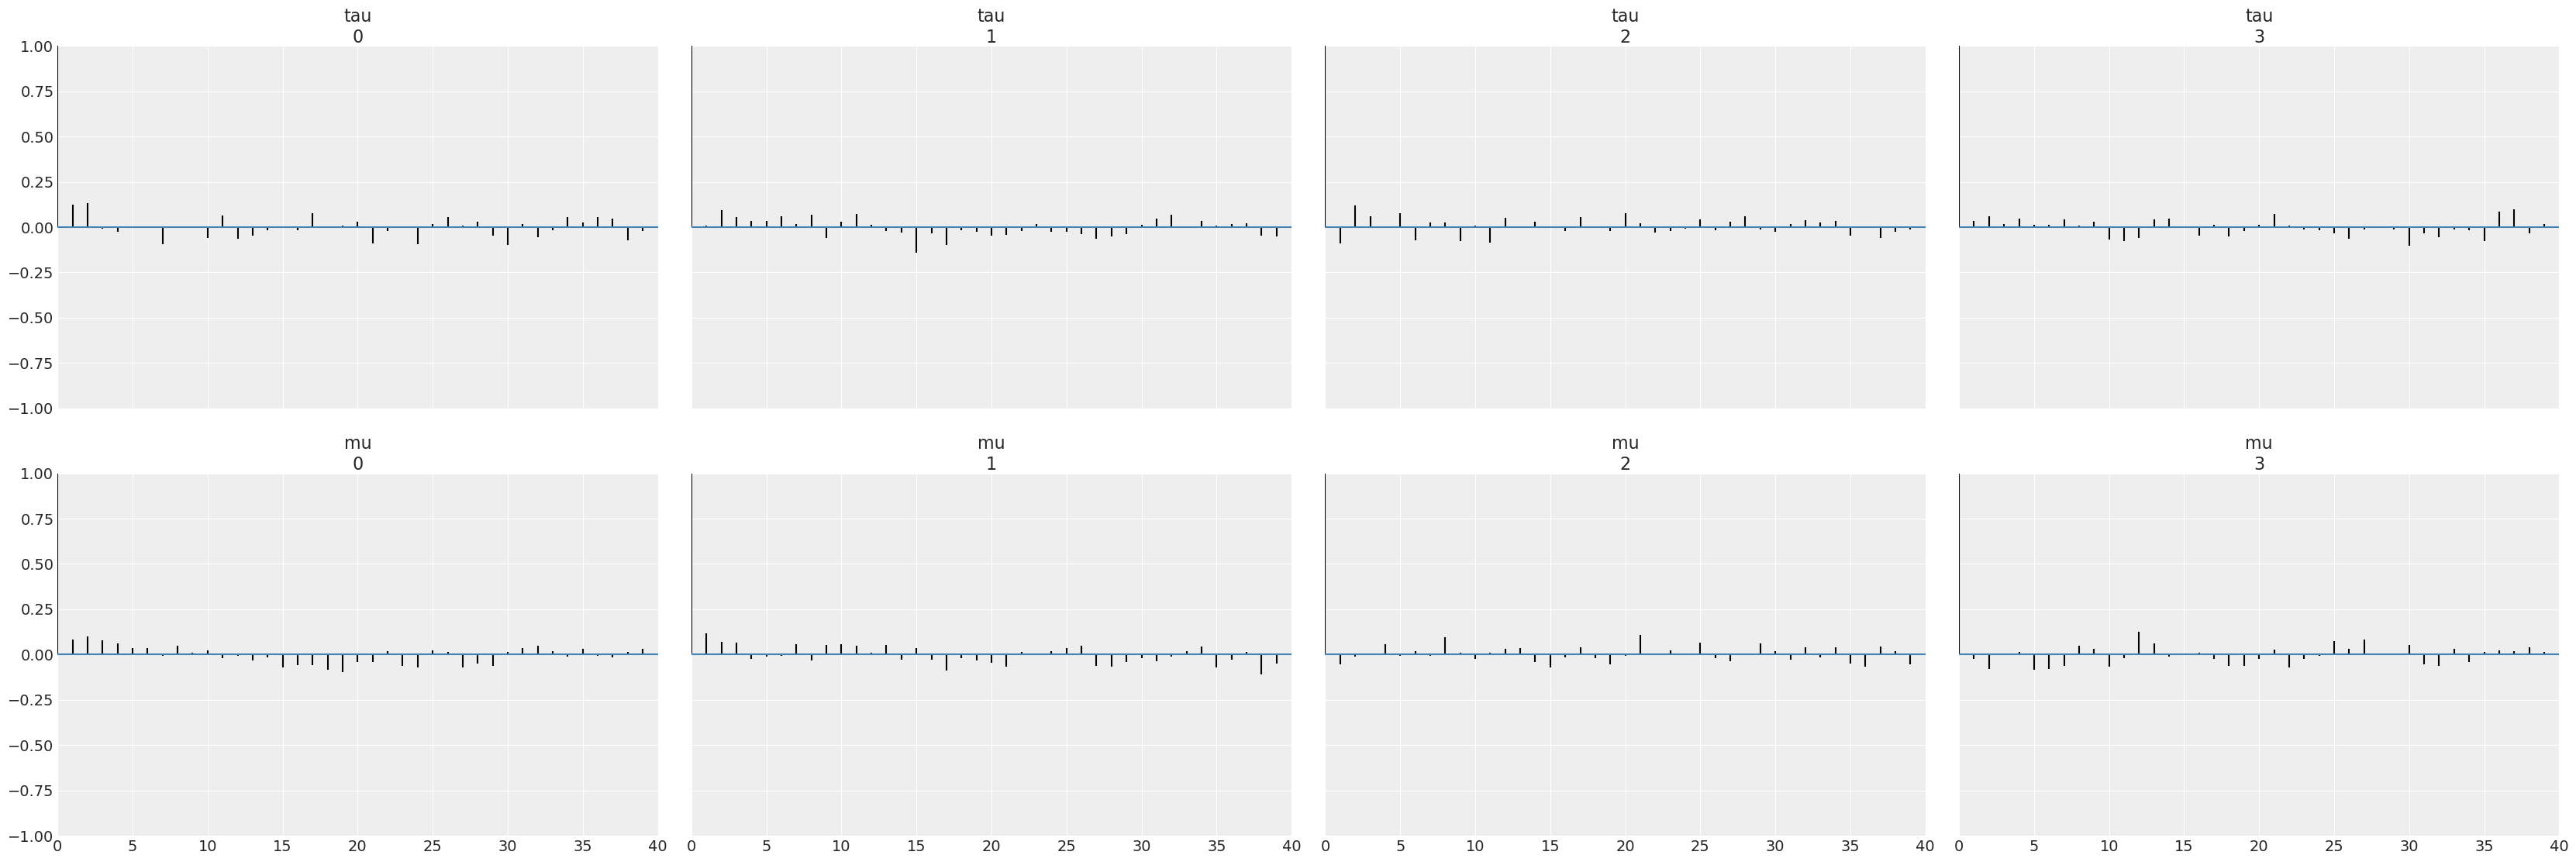

In [36]:
az.plot_autocorr(stan_data,max_lag=40,var_names=("tau","mu"))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8e8f117890>],
      dtype=object)

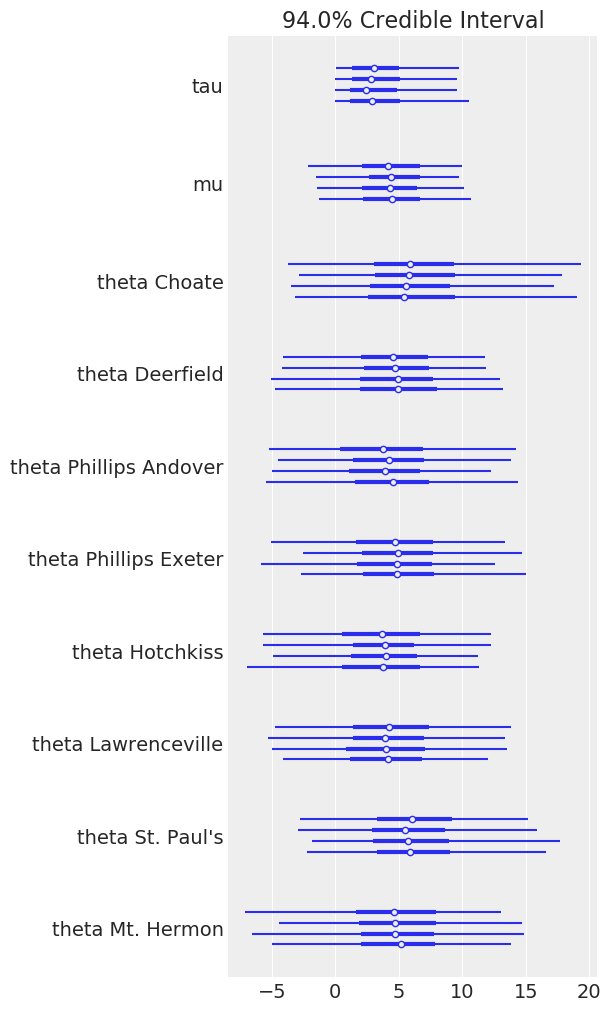

In [37]:

az.plot_forest(stan_data, var_names=("tau","mu", "theta"))

In [38]:

az.plot_forest?

Signature:
az.plot_forest(
    data,
    kind='forestplot',
    model_names=None,
    var_names=None,
    transform=None,
    coords=None,
    combined=False,
    credible_interval=None,
    rope=None,
    quartiles=True,
    ess=False,
    r_hat=False,
    colors='cycle',
    textsize=None,
    linewidth=None,
    markersize=None,
    ridgeplot_alpha=None,
    ridgeplot_overlap=2,
    ridgeplot_kind='auto',
    ridgeplot_quantiles=None,
    figsize=None,
    ax=None,
    backend=None,
    backend_config=None,
    backend_kwargs=None,
    show=None,
)
Docstring:
Forest plot to compare credible intervals from a number of distributions.

Generates a forest plot of 100*(credible_interval)% credible intervals from
a trace or list of traces.

Parameters
----------
data : obj or list[obj]
    Any object that can be converted to an az.InferenceData object
    Refer to documentation of az.convert_to_dataset for details
kind : str
    Choose kind of plot for main axis. Supports "forestplot" or 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8e8ef66090>,
      dtype=object)

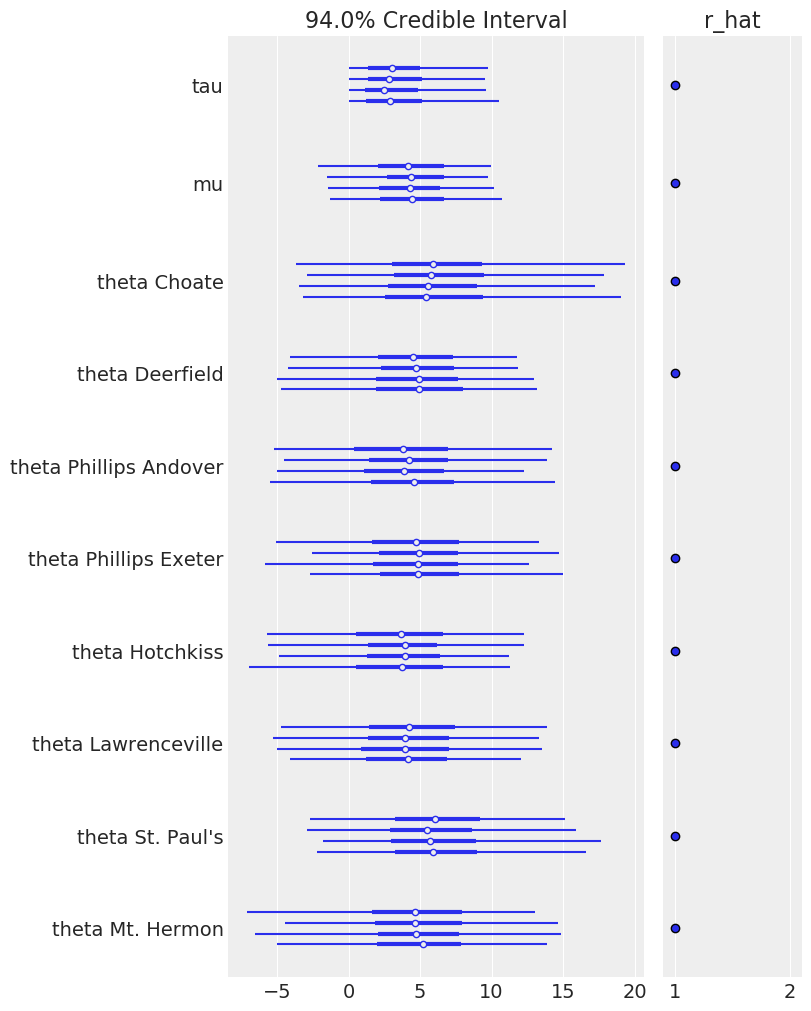

In [39]:

az.plot_forest(stan_data, var_names=("tau","mu", "theta"),r_hat=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8e8ed17750>,
      dtype=object)

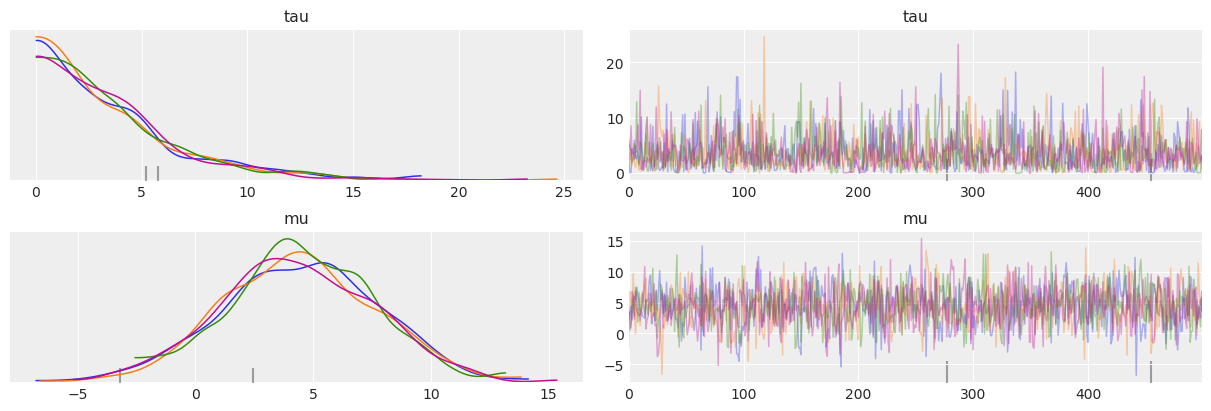

In [41]:
az.plot_trace(stan_data, var_names=("tau","mu"))

In [40]:
az.plot_trace?

Signature:
az.plot_trace(
    data: arviz.data.inference_data.InferenceData,
    var_names: Union[List[str], NoneType] = None,
    transform: Union[Callable, NoneType] = None,
    coords: Union[Dict[str, List[Any]], NoneType] = None,
    divergences: Union[str, NoneType] = 'bottom',
    figsize: Union[Tuple[float, float], NoneType] = None,
    rug: bool = False,
    lines: Union[List[Tuple[str, Dict[str, List[Any]], Any]], NoneType] = None,
    compact: bool = False,
    compact_prop: Union[Tuple[str, Any], NoneType] = None,
    combined: bool = False,
    chain_prop: Union[Tuple[str, Any], NoneType] = None,
    legend: bool = False,
    plot_kwargs: Union[Dict[str, Any], NoneType] = None,
    fill_kwargs: Union[Dict[str, Any], NoneType] = None,
    rug_kwargs: Union[Dict[str, Any], NoneType] = None,
    hist_kwargs: Union[Dict[str, Any], NoneType] = None,
    trace_kwargs: Union[Dict[str, Any], NoneType] = None,
    ax=None,
    backend: Union[str, NoneType] = None,
    backend_config

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8e8dce1c10>,
      dtype=object)

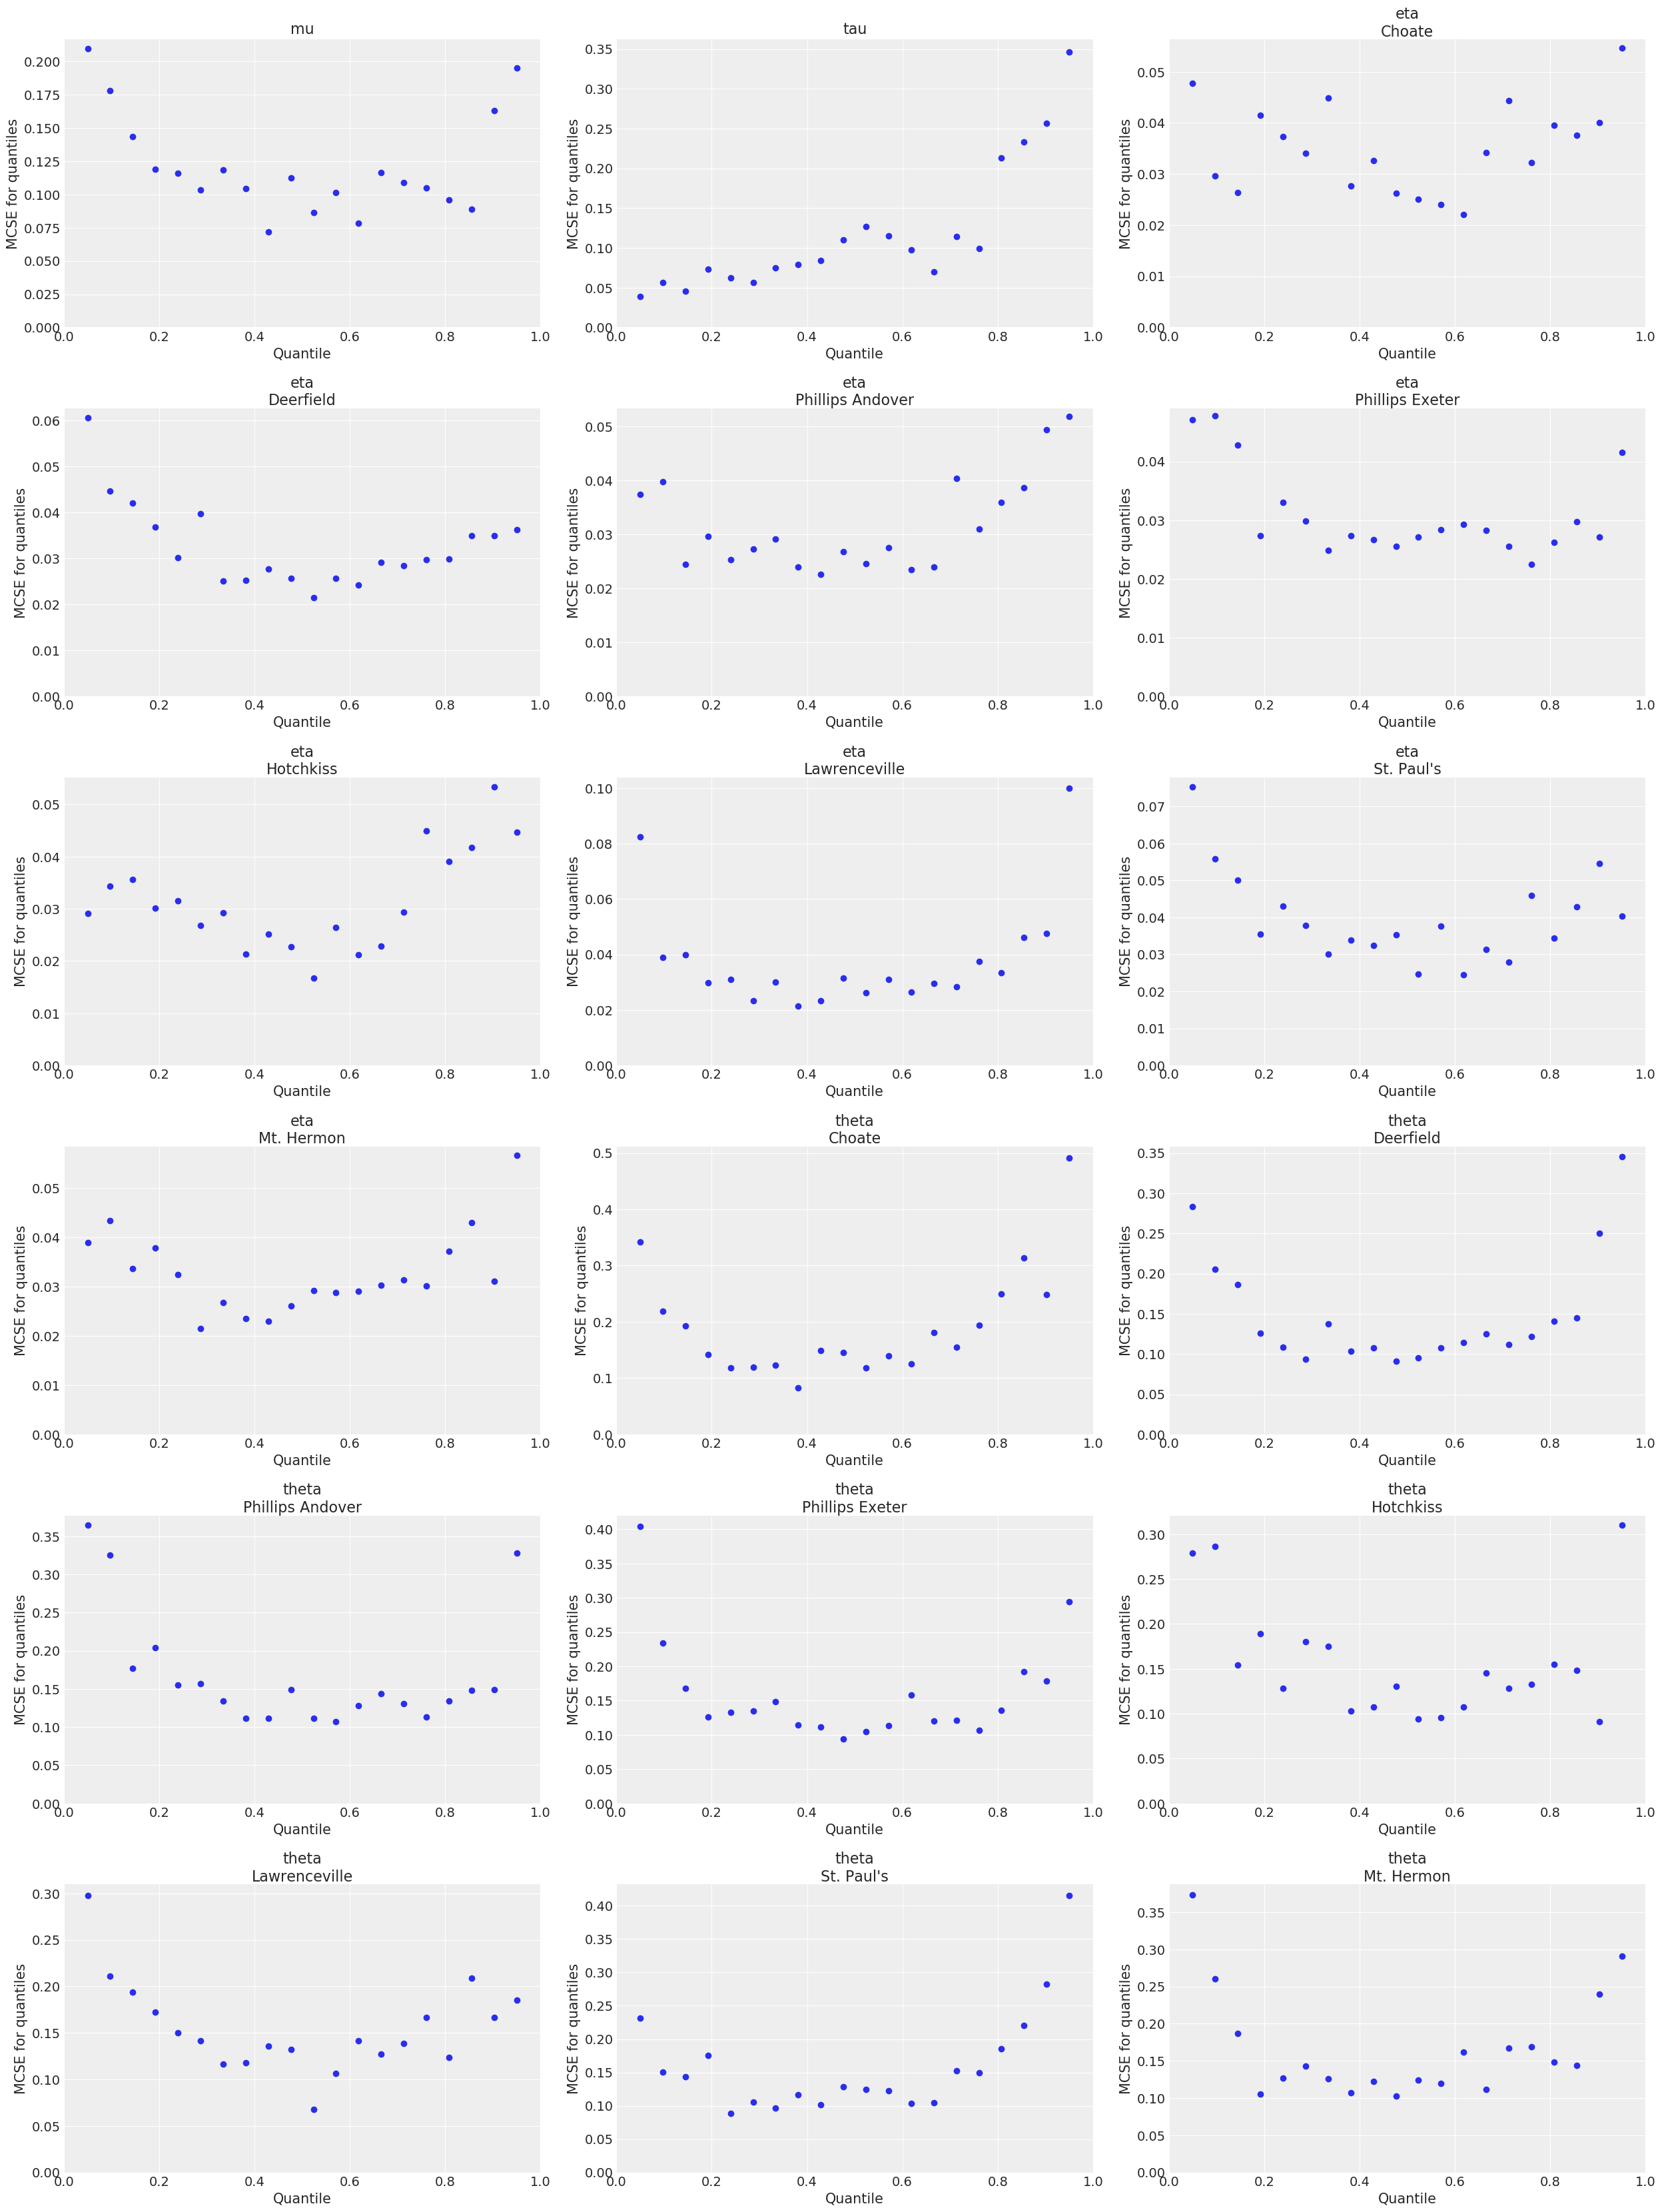

In [43]:
az.plot_mcse(stan_data)

In [45]:
az.plot_mcse?

Signature:
az.plot_mcse(
    idata,
    var_names=None,
    coords=None,
    errorbar=False,
    figsize=None,
    textsize=None,
    extra_methods=False,
    rug=False,
    rug_kind='diverging',
    n_points=20,
    ax=None,
    rug_kwargs=None,
    extra_kwargs=None,
    text_kwargs=None,
    backend=None,
    backend_kwargs=None,
    show=None,
    **kwargs,
)
Docstring:
Plot quantile or local Monte Carlo Standard Error.

Parameters
----------
idata : obj
    Any object that can be converted to an az.InferenceData object
    Refer to documentation of az.convert_to_dataset for details
var_names : list of variable names, optional
    Variables to be plotted.
coords : dict, optional
    Coordinates of var_names to be plotted. Passed to `Dataset.sel`
errorbar : bool, optional
    Plot quantile value +/- mcse instead of plotting mcse.
figsize : tuple, optional
    Figure size. If None it will be defined automatically.
textsize: float, optional
    Text size scaling factor for labels, tit

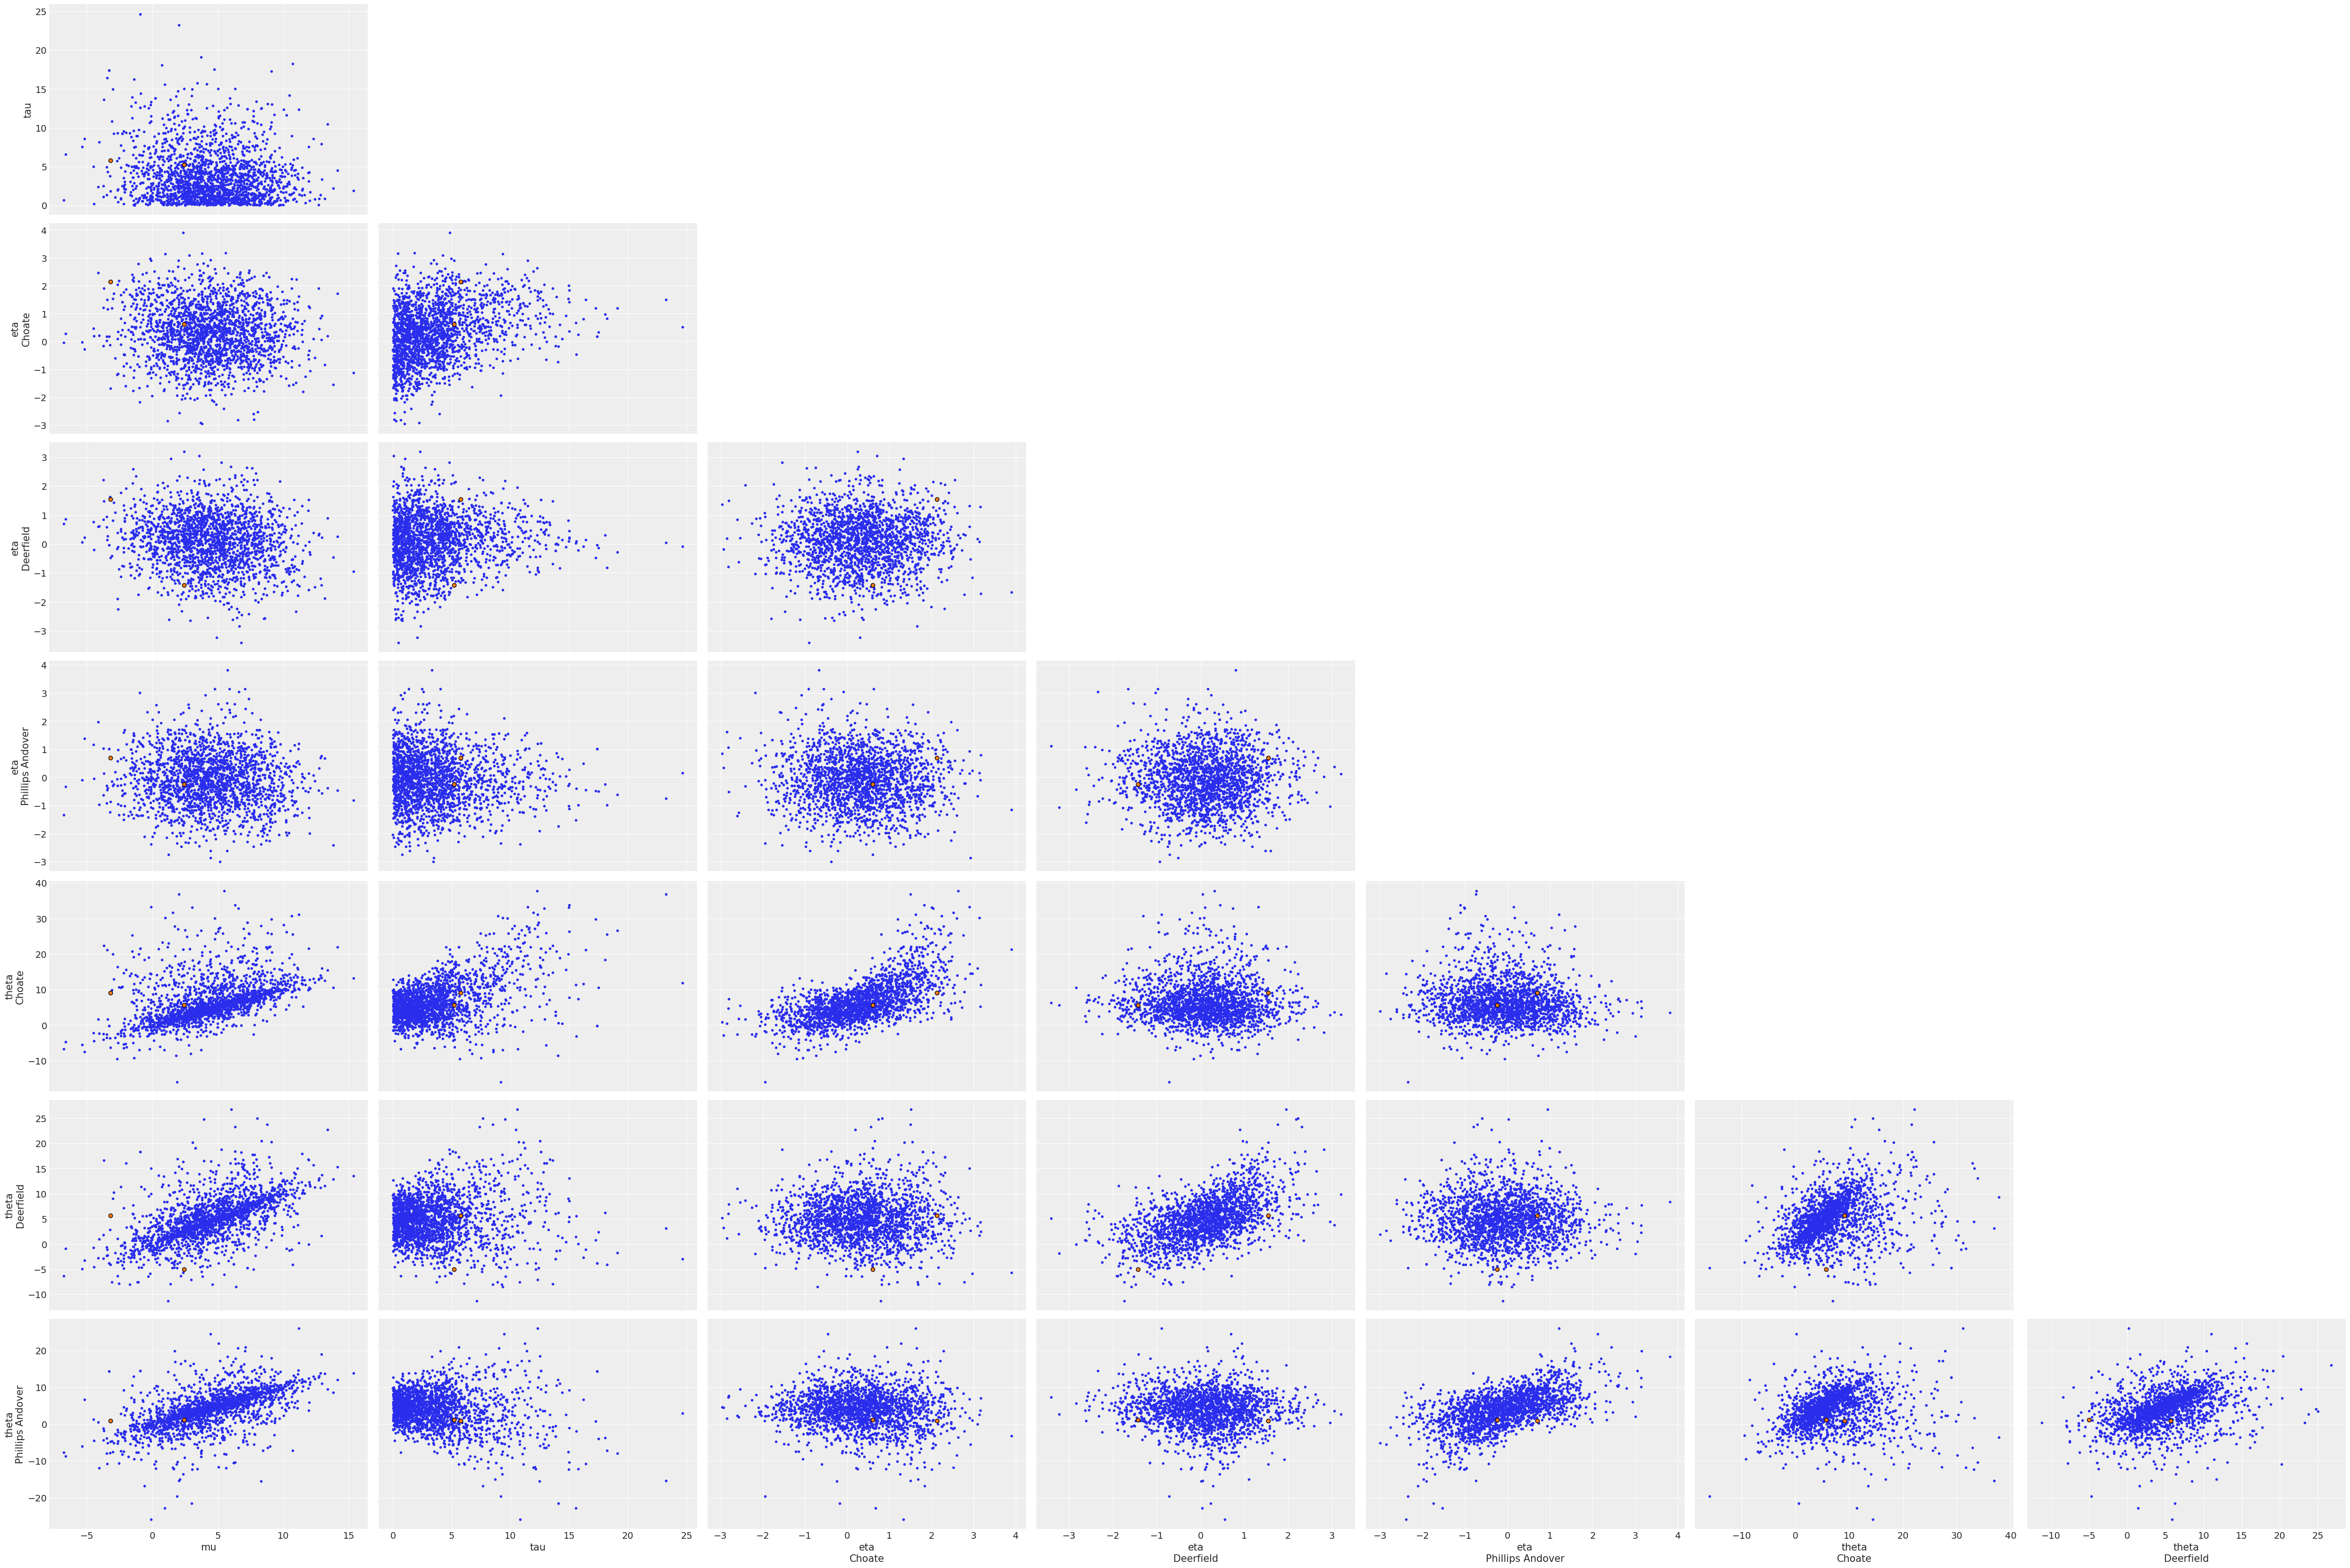

In [46]:
az.plot_pair(stan_data, coords={'school': ['Choate', 'Deerfield', 'Phillips Andover']}, divergences=True);

In [52]:
az.geweke(stan_data.posterior.mu[0,:])


array([[ 0.00000000e+00,  2.82217904e-02],
       [ 1.30000000e+01,  6.02335147e-02],
       [ 2.60000000e+01,  8.17532688e-02],
       [ 3.90000000e+01,  9.79416605e-02],
       [ 5.20000000e+01,  1.09769073e-01],
       [ 6.50000000e+01, -8.84177211e-02],
       [ 7.80000000e+01, -7.11777253e-02],
       [ 9.10000000e+01, -1.07744137e-01],
       [ 1.05000000e+02,  1.66558768e-01],
       [ 1.18000000e+02, -4.57357110e-02],
       [ 1.31000000e+02,  8.20859179e-02],
       [ 1.44000000e+02,  5.28464937e-02],
       [ 1.57000000e+02,  6.65838593e-04],
       [ 1.70000000e+02, -1.42179138e-01],
       [ 1.83000000e+02, -1.98996751e-02],
       [ 1.96000000e+02, -3.37794869e-02],
       [ 2.10000000e+02, -7.95603667e-02],
       [ 2.23000000e+02,  1.98963949e-01],
       [ 2.36000000e+02,  2.07534295e-01],
       [ 2.49000000e+02, -1.50309694e-01]])

In [53]:
az.geweke?


Signature:       az.geweke(ary, first=0.1, last=0.5, intervals=20)
Call signature:  az.geweke(*args, **kwargs)
Type:            maybe_numba_fn
String form:     <arviz.utils.maybe_numba_fn object at 0x7f8e93986f90>
File:            ~/anaconda3/envs/stan/lib/python3.7/site-packages/arviz/stats/diagnostics.py
Docstring:      
Compute z-scores for convergence diagnostics.

Compare the mean of the first % of series with the mean of the last % of series. x is divided
into a number of segments for which this difference is computed. If the series is converged,
this score should oscillate between -1 and 1.

Parameters
----------
ary : 1D array-like
  The trace of some stochastic parameter.
first : float
  The fraction of series at the beginning of the trace.
last : float
  The fraction of series at the end to be compared with the section
  at the beginning.
intervals : int
  The number of segments.

Returns
-------
scores : list [[]]
  Return a list of [i, score], where i is the starting index 

## <span style="color:#4361EE">Referencias</span>

[PyStan: Getting Started](https://pystan.readthedocs.io/en/latest/getting_started.html)

[Manual de usuario de Stan, versión 2.22](https://mc-stan.org/docs/2_22/stan-users-guide/index.html)


```{bibliography}
:filter: docname in docnames
```